<a href="https://colab.research.google.com/github/Ratul2200/Drug_repurposing-for-SARS_CoV2/blob/main/Vina_score_gan_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic Libraries
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm, trange

# sklearn libraries
from sklearn.model_selection import train_test_split,RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import pickle

In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.5 MB 1.5 MB/s 


In [ ]:
from rdkit import rdBase
from rdkit import Chem,DataStructs
print(rdBase.rdkitVersion)

2022.03.1


In [ ]:
! git clone https://github.com/isayev/ReLeaSE.git

Cloning into 'ReLeaSE'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 548 (delta 0), reused 2 (delta 0), pack-reused 545
Receiving objects: 100% (548/548), 449.76 MiB | 19.10 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Checking out files: 100% (29/29), done.


In [ ]:
sys.path.append('/content/ReLeaSE/release')

In [ ]:
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

## Load Data and Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
print(os.getcwd())

Mounted at /content/gdrive
/content


## Setting up Generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol.

In [ ]:
#gen_data_path = '/content/ReLeaSE/data/chembl_22_clean_1576904_sorted_std_final.smi'

#tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
#          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
#          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [ ]:
with open('/content/gdrive/MyDrive/Models/gan_num/generator_data.pkl','rb') as file:
    gen_data = pickle.load(file)

### Utility Functions

In [ ]:
def plot_hist(prediction, n_to_generate):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted Vina Scores', 
           title='Distribution of predicted vina scores for generated molecules')
    plt.show()

In [ ]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

In [ ]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [ ]:
model_path = '/content/ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn'

In [ ]:
my_generator.load_model(model_path)

In [ ]:
! pip install mordred

     |████████████████████████████████| 128 kB 5.1 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=5d289eb040e3a7902b6fa7120b783315d122b55ba2d13941add5c9821c4dba5e
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


## Setting up Predictor

In [ ]:
from data import PredictorData
from utils import get_desc, get_fp
from mordred import Calculator, descriptors

In [ ]:
calc = Calculator(descriptors, ignore_3D=True)

In [ ]:
pred_data = PredictorData(path='/content/gdrive/MyDrive/Datasets/Drug Repurposing/vina_scores_expt_gan_predictor.csv', get_features=get_fp)

In [ ]:
from predictor import VanillaQSAR
from sklearn.ensemble import RandomForestRegressor as RFR

In [ ]:
model_instance = RFR
model_params = {'n_estimators': 200, 'n_jobs': 10}

In [ ]:
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='regressor')

In [ ]:
my_predictor.fit_model(pred_data, cv_split='random')

Generating molecules...: 100%|██████████| 6000/6000 [09:58<00:00, 10.03it/s]


Mean value of predictions: -7.922073094672322
Proportion of valid SMILES: 0.629


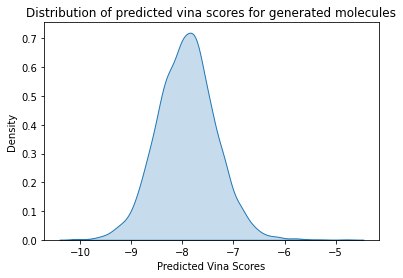

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=6000)

##Biasing the distribution of the generator to have lowst vina score with reinforcement learning

In [ ]:
from reinforcement import Reinforcement

In [ ]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 100

In [ ]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [ ]:
def get_reward_min(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(-prop[0]/3 + 3)

The reward function we will use here is
\begin{align}
R(s)=exp(-\frac{predictor(s)}{3})
\end{align}

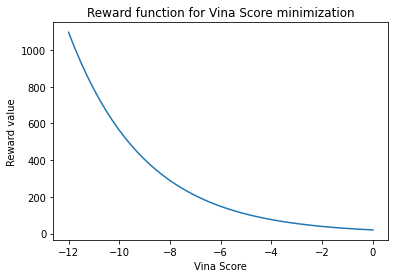

In [ ]:
x = np.linspace(-12, 0)
y = np.exp(-x/3 + 3)
plt.plot(x, y)
plt.xlabel('Vina Score')
plt.ylabel('Reward value')
plt.title('Reward function for Vina Score minimization')
plt.show()

In [ ]:
my_generator_min = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)
my_generator_min.load_model(model_path)

In [ ]:
RL_min = Reinforcement(my_generator_min, my_predictor, get_reward_min)

In [ ]:
rewards_min = []
rl_losses_min = []

Policy gradient...: 100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


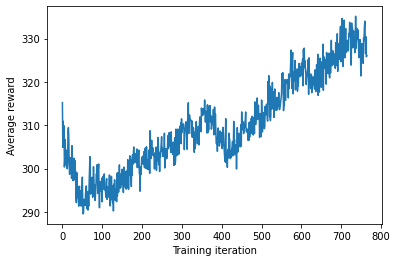

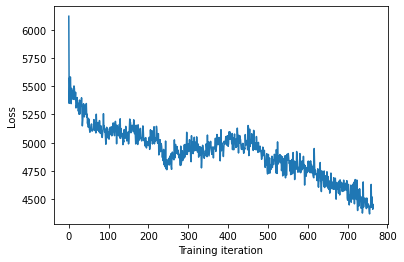

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


Mean value of predictions: -8.322422919503195
Proportion of valid SMILES: 0.86


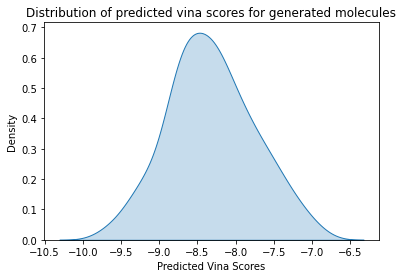

Sample trajectories:
C#CCC=CCN1CCN(C(=O)CCCc2ccccc2)C(C)C1
C#Cc1ccc(NCCCCCCCCN2CCN(CC)CC2)cc1
C=C(C)CCC(CCCCC)OC(=O)CCCNC(=O)c1nc(-c2ccccc2Cl)ccc1OC
C=C(CCSC)NC(=O)CN1C(=O)NCCc2ccccc21
CC(=CC(=O)O)CCC(C)CC(O)CC1CCC(C)O1


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


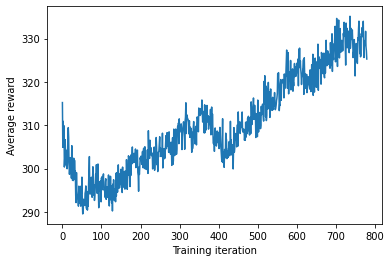

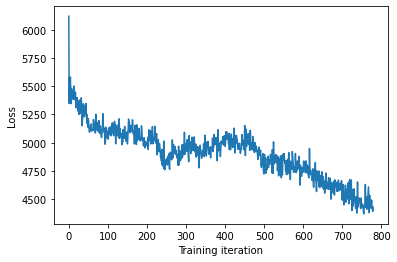

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


Mean value of predictions: -8.364338319675202
Proportion of valid SMILES: 0.865


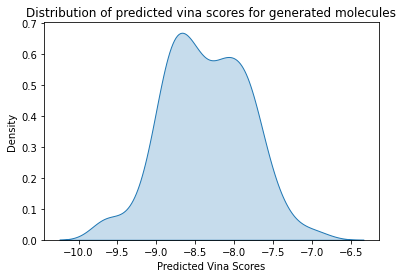

Sample trajectories:
C1CCCsN(C2CCCC2)CCC1
C=C(C)CSc1nc2ccccc2o1
C=C1CC(c2ccc(CC)cc2)CC(N2CCN(C)CC2)C1
CC(=NNc1ccnc(C)n1)c1ccccc1
CC(=O)N(c1ccccc1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


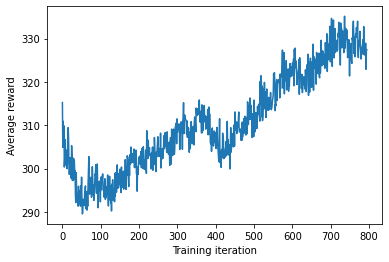

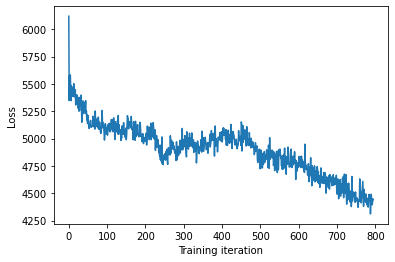

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


Mean value of predictions: -8.393715069473469
Proportion of valid SMILES: 0.9


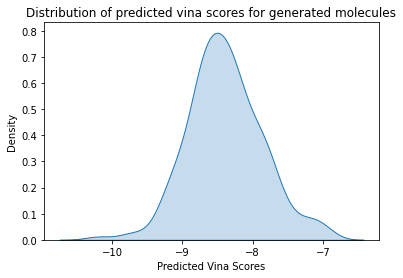

Sample trajectories:
C=C(C)C(=O)NC1C(CC)C1C(=O)NC(C)Cc1ccccc1
C=C(C)c1cnn(CC)c1
C=CCN(CCCCCCl)CCCNc1ccccc1
CC(=N)N(C)CCNCC#N
CC(=O)C(C)CC(=O)CCCCN1CCCN1C(=O)NC(C)(C)C


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.34s/it]


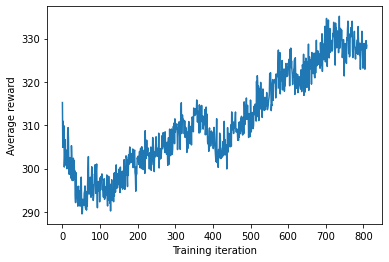

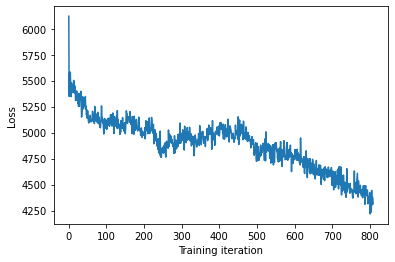

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 14.19it/s]


Mean value of predictions: -8.338317668794367
Proportion of valid SMILES: 0.89


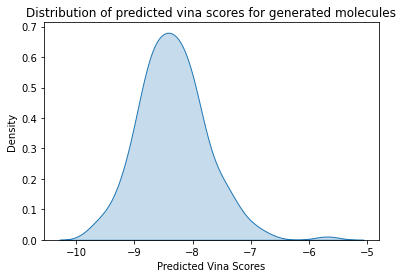

Sample trajectories:
C=CCCCCCCCCCCCCCC(OC=CC1C(C)CC1OCC)C(=O)NN(Cc1ccccc1)C(=O)O
C=CCc1cccc(OCCC(=O)OCC)c1
CC(=O)N(C(=O)Cc1ccc(Cl)cc1)c1ccccc1
CC(=O)Nc1ccc(C(=O)NCCCCOc2ccc(C)cc2)cc1
CC(=O)Nc1cccc(C(=O)Nc2cccc(C(F)(F)F)c2)c1


Policy gradient...: 100%|██████████| 15/15 [01:07<00:00,  4.50s/it]


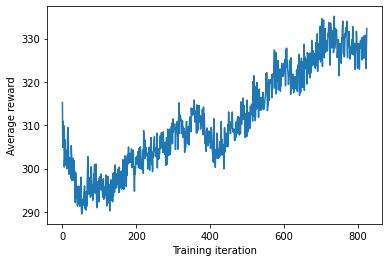

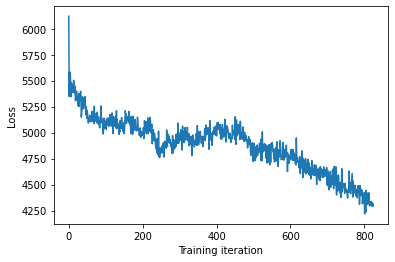

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


Mean value of predictions: -8.336531373317278
Proportion of valid SMILES: 0.87


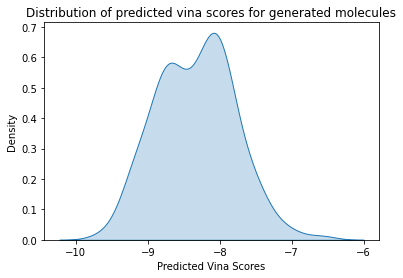

Sample trajectories:
C=CC(C)COCCNC1CCc2ccccc2CO1
C=CCN(C)CCCNC(=O)CBr
C=CCNC(=O)NCCCNC1=C(c2ccccc2)CCCC1
CC(=O)N1CCOCC1
CC(=O)NC(C)C(=O)O


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.32s/it]


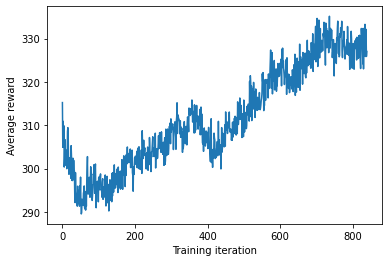

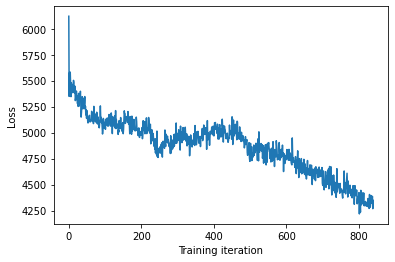

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 14.14it/s]


Mean value of predictions: -8.345133380829354
Proportion of valid SMILES: 0.875


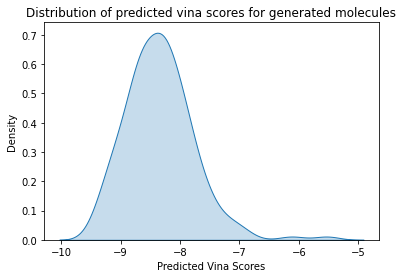

Sample trajectories:
C=C(CNC(=O)Cc1ccccc1)c1ccc(CC)cc1
C=C1CCC(C)C(O)CC2(C)CCCC23CCCC2(O)C(C)CCC2C3C1
C=CC(Nc1cc(C)ccc1C)c1ccccc1
C=CCOc1cc(CNCCCCCOc2ccccc2)ccc1O
C=CNCCCCCNCCCCCNCCCCNCCCC


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.32s/it]


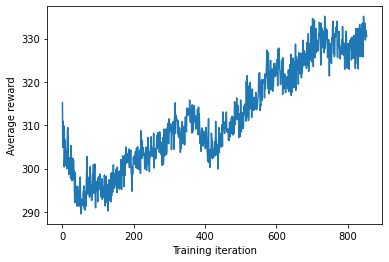

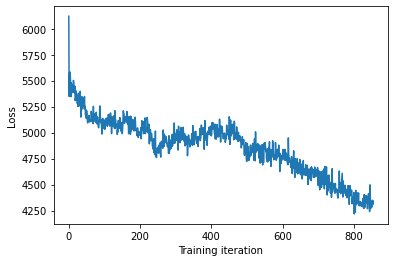

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 14.25it/s]


Mean value of predictions: -8.395544523953198
Proportion of valid SMILES: 0.895


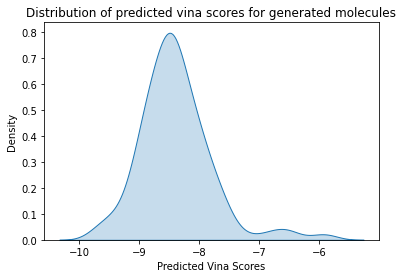

Sample trajectories:
C=C(C)C=CC(=O)NC(C(=O)NCCCCCC)C(OC(C)=O)C(O)Cc1ccccc1
C=C(OC(C)=O)C(C)C(=O)NCCCCCCCCCCNC(=O)NCCCCCCCCC1CCC(=O)N1
C=CC(=O)Nc1ccccc1
CC(=C(C#N)c1ccccc1)c1ccccc1
CC(=NNC(=S)Nc1ccccc1)c1ccccc1Cl


Policy gradient...: 100%|██████████| 15/15 [01:02<00:00,  4.17s/it]


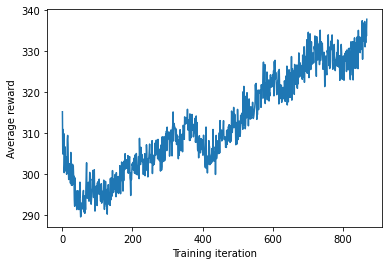

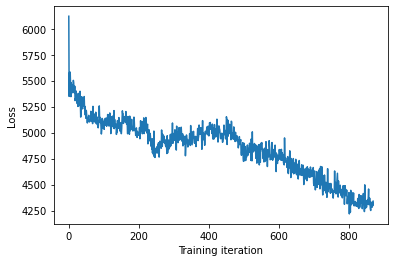

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.91it/s]


Mean value of predictions: -8.344895787336467
Proportion of valid SMILES: 0.89


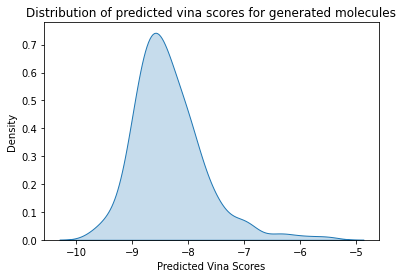

Sample trajectories:
C=CCCNC(=O)C1CNCN1c1ccc(F)cc1
CC(=NNC(=S)NCC(=O)NCC(=O)Nc1ccccc1C)c1ccccc1
CC(=O)CN1CC(c2ccccc2)CC1=O
CC(=O)NC(=O)c1nccc(C(F)(F)F)n1
CC(=O)NCCSc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:02<00:00,  4.17s/it]


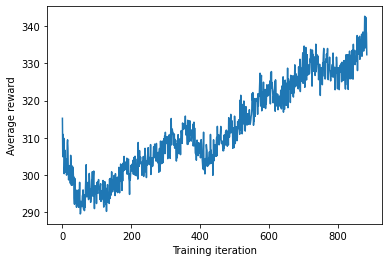

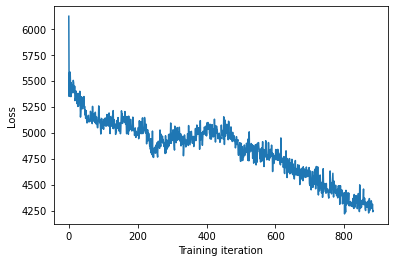

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.86it/s]


Mean value of predictions: -8.384327288844068
Proportion of valid SMILES: 0.93


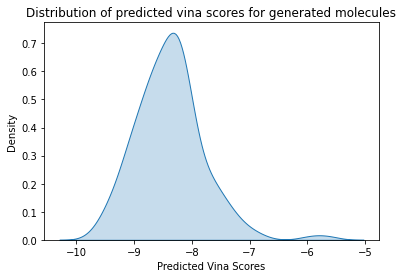

Sample trajectories:
C=CC(OCCC)C1CCC2(C)OC(C)(C)OC12
CC(=O)NCC(=O)Nc1ccccc1C
CC(=O)NCCCNCCN(Cc1ccccc1)C(C)C
CC(=O)Nc1ccccc1
CC(=O)SCC(=O)OCC(C)(C)C


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.40s/it]


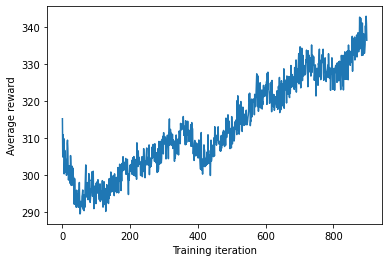

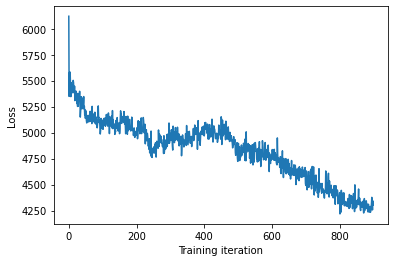

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


Mean value of predictions: -8.426014035800032
Proportion of valid SMILES: 0.885


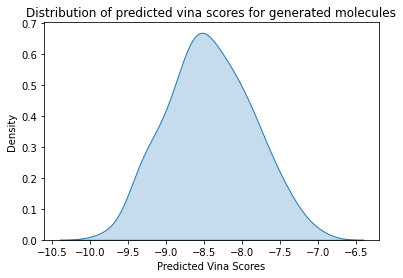

Sample trajectories:
C1CCC(N2CCCCCC2)CC1
CC(=NNC(=O)c1ccccc1)c1ccccc1
CC(=NNS(=O)(=O)c1ccccc1)c1cccs1
CC(=O)NCCN1CCN(c2ccc(C)cc2)CC1
CC(=O)NCc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


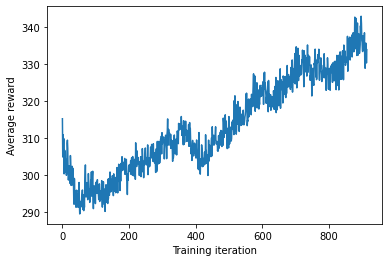

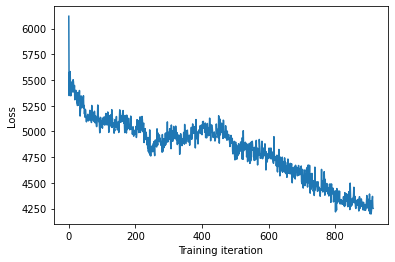

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Mean value of predictions: -8.32945450747677
Proportion of valid SMILES: 0.885


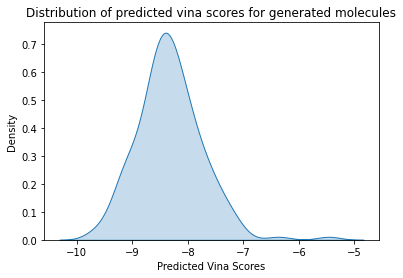

Sample trajectories:
C1CCCN(CCNC2CCOCC2)CCC1
CC(=O)COC(=O)N(C)C(C)=NN1c2ccc(Cl)cc2C(=O)C1CN1CC(C)C1=O
CC(=O)N(C)CCCCNC(=O)C(Cc1ccccc1)NC(=O)C(Cc1ccccc1)NC(=O)OCc1ccccc1
CC(=O)N1CCC2(CCCCC2)O1
CC(=O)N1N=C(c2ccccc2)CC1c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


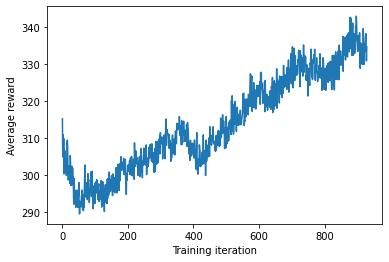

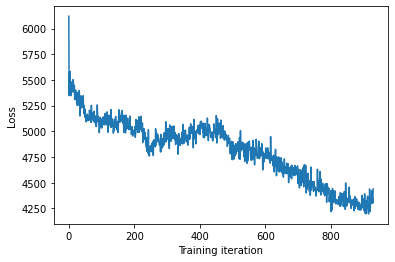

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 14.17it/s]


Mean value of predictions: -8.449231352963393
Proportion of valid SMILES: 0.88


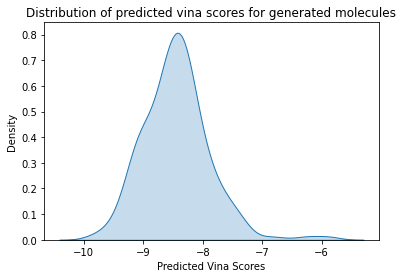

Sample trajectories:
C=C(C(=O)NCCNc1ccccc1)c1ccc(OC)cc1
C=CC1C(=O)N(c2cccc(OC)c2)N=C1c1ccccc1
C=CCC(C)C(=O)NC(CCCNC(=N)N)C(=O)N1CCCC1CNC(C)C
CC(=O)C1CCN(CCOc2cccc(C(=O)NCCCF)c2)CC1
CC(=O)NCNC(=O)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.30s/it]


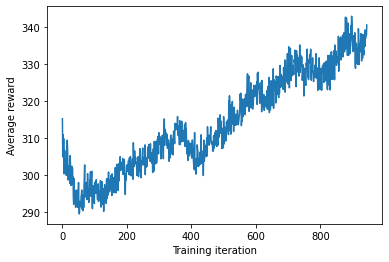

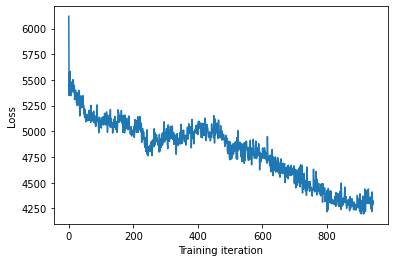

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


Mean value of predictions: -8.340473914742354
Proportion of valid SMILES: 0.9


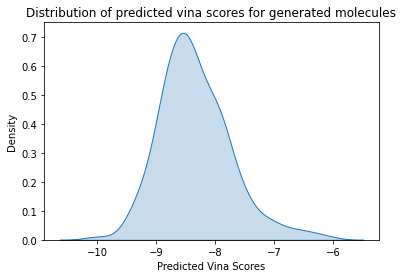

Sample trajectories:
C=CCN1CCN(C(=O)C(CC(=O)O)NC(=O)NC(CC(C)C)C(=O)O)CC1
C=CCNCCCNCCCCCCNC(=O)CCCCCCCC
C=CCSC(C)=NCCCC(CCC)CCCCNCC(C)CCCC(C)C
C=CCSCCCCCCCCCCCCOc1ccccc1
CC(=O)N(CCCCCCCCCCNC(=O)OCc1ccccc1)C(=O)NCCCN


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


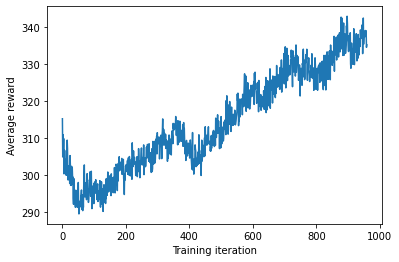

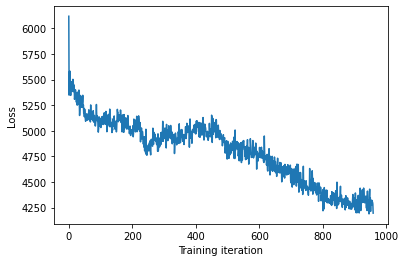

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.65it/s]


Mean value of predictions: -8.34283173806479
Proportion of valid SMILES: 0.89


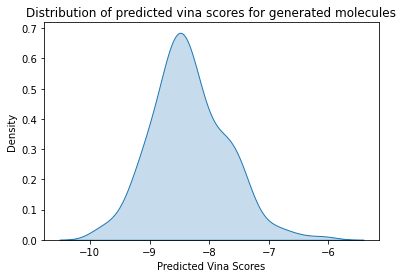

Sample trajectories:
C=CCCCCCCCCC(=O)NCCCN(CC)CC
C=Cc1ccccc1CN1CCCCC1
CC(=NOC(=O)COc1ccccc1)c1ccccc1
CC(=O)C=CC=CC1=NNC(=O)C1
CC(=O)N1CCC(c2cnc(N(C)C)c(CCN(C)C)c2)CC1


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.27s/it]


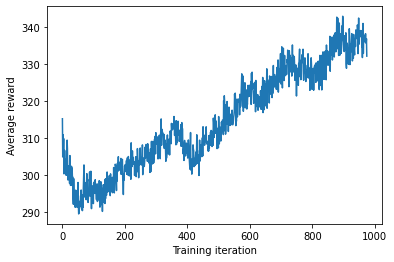

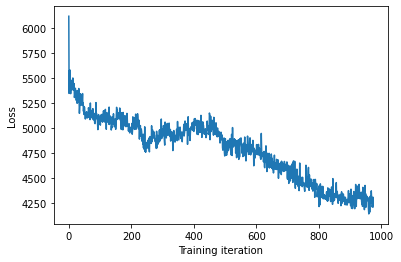

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Mean value of predictions: -8.425419408170825
Proportion of valid SMILES: 0.88


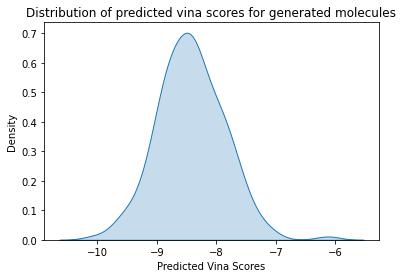

Sample trajectories:
C=C1C(C(=O)O)C(=O)NN1C
C=CCCC(NC(=O)c1ccccc1C)C(=O)OC
C=CCNCC(O)CC(C)=NOCC(C)C
CC(=CC(=O)Nc1ccccc1C)Nc1ccccc1
CC(=O)N1CCC(c2c(C)cccc2C)CC1


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.34s/it]


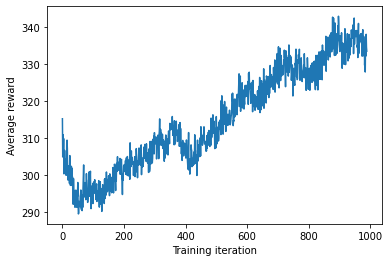

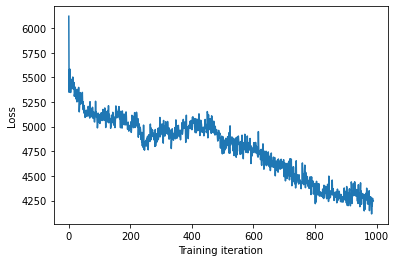

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Mean value of predictions: -8.30739594231554
Proportion of valid SMILES: 0.895


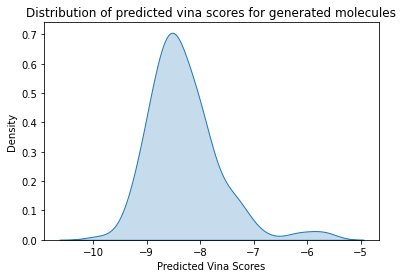

Sample trajectories:
C#CCNCCCNC(=O)NCCCC
C=C(C)NC(=O)CNC(=O)C=Cc1ccccc1
C=CC(C)C(=O)OCC(CC#CN(C)C)C(C)C
C=CCN(C)C
C=CCN(Cc1ccccc1)C(C)C(=O)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.35s/it]


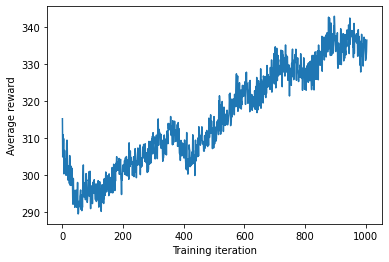

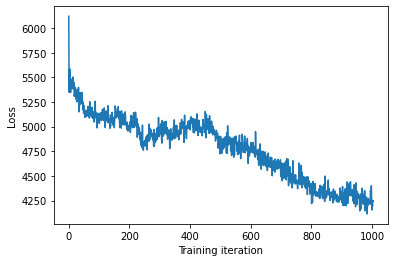

Generating molecules...: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Mean value of predictions: -8.45149133269964
Proportion of valid SMILES: 0.91


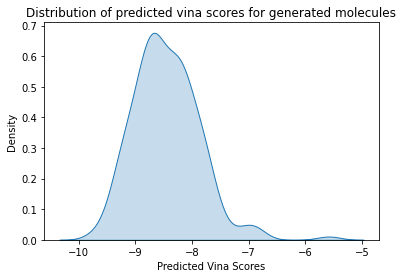

Sample trajectories:
C#CCCCCCCCCCCCCCCC
C#CCOCCCCNC(=O)CCCCCCCP(=O)(O)O
C=C1C=C(OCc2ccccc2)C(C)CN1
C=CCC(OC1CC(C(=O)O)C(O)CCCCCCCCCCCCCCNC(=O)CCCCCCCCCCN1CCCCC)C(O)C(=O)CCCCCCC
C=CCNC(=O)Cc1ccc(OC)cc1


Policy gradient...: 100%|██████████| 15/15 [01:02<00:00,  4.18s/it]


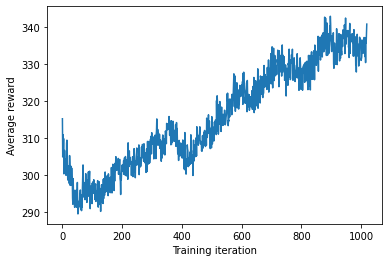

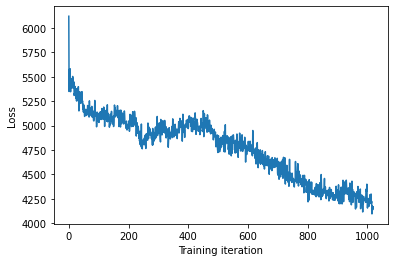

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


Mean value of predictions: -8.423060968988665
Proportion of valid SMILES: 0.9


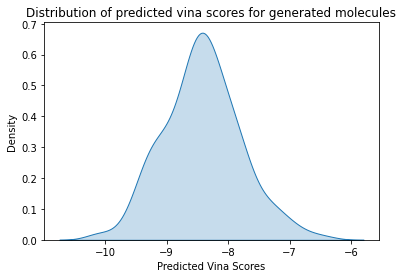

Sample trajectories:
C=C(C)CCCN1CCCCC1
C=CCCCCCCCCCCCCCCl
C=CCNS(=O)(=O)c1cccc(Cl)c1
CC(=O)C(NC(=O)C(Cc1ccccc1)NC(=O)C1CCCO1)C(=O)NCCNc1ccccc1
CC(=O)N(Cc1ccccc1)CC(O)CNC(C)Cc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.32s/it]


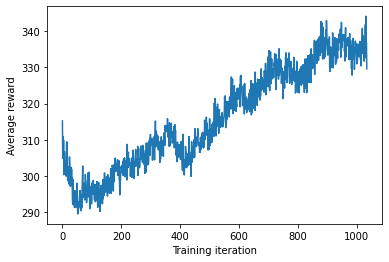

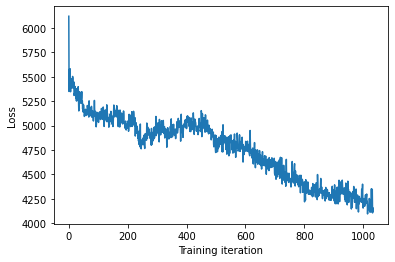

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


Mean value of predictions: -8.401116409044347
Proportion of valid SMILES: 0.9


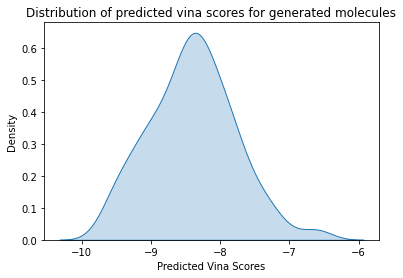

Sample trajectories:
CC(=NNC(=O)c1ccccc1)c1ccccc1
CC(=O)C(=O)CCCCCCCCCCN
CC(=O)NC(C(=O)O)C(C)C
CC(=O)NCCCCCCNCCc1ccccc1
CC(C(=O)N1CCCCC1C(=O)NC(C)(C)C)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.12s/it]


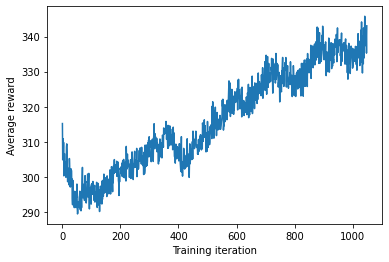

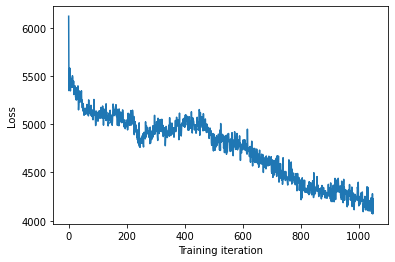

Generating molecules...: 100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


Mean value of predictions: -8.370508608590331
Proportion of valid SMILES: 0.915


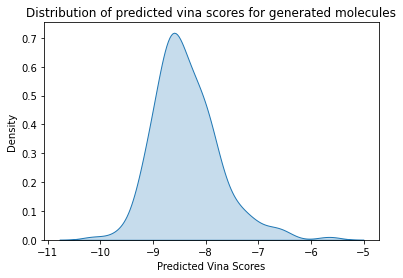

Sample trajectories:
C=CC(=O)NCCC1(c2ccccc2)COCC1OC1OC(c2ccccc2)C(O)C(O)C1O
C=CCNC(=O)C(C)NC(=O)C(C)NC(=O)CCCCCN(CCCC)CCCCNC(=O)C(C)C
C=CCOC(=O)CCCCCCC=CC(C)CCCCCC
CC#CCCCCCCCCCCCC
CC(=O)NC(CO)CNC(C)C


Policy gradient...: 100%|██████████| 15/15 [01:03<00:00,  4.22s/it]


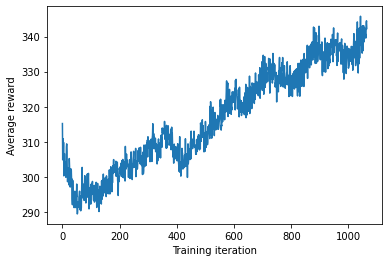

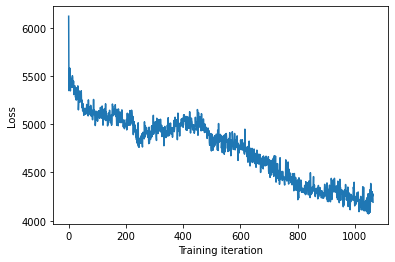

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 14.14it/s]


Mean value of predictions: -8.447622434519648
Proportion of valid SMILES: 0.915


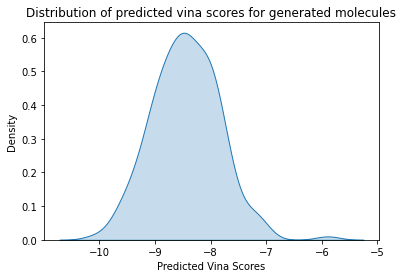

Sample trajectories:
C#Cc1cccc(C(=O)N2CCN(C(=O)CNCc3ccccc3)CC2)c1
C1CCC2CCCCN2CC1
C=CCCC(=O)NCCNCCSC
C=CCCOC(Cc1ccccc1)C(O)C(C)CCC=C(O)C=CCC(CO)CCCCCCCCCCCCCCCCCC
C=CCNC(=O)COc1ccccc1F


Policy gradient...: 100%|██████████| 15/15 [01:03<00:00,  4.26s/it]


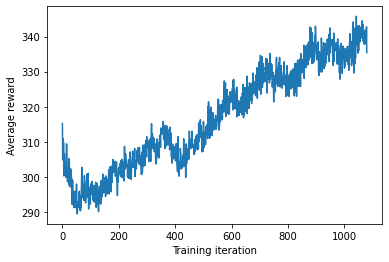

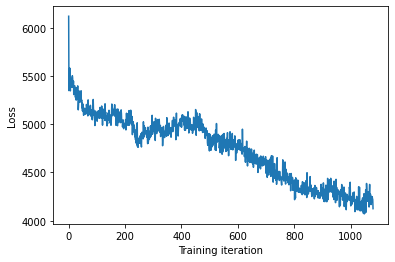

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Mean value of predictions: -8.405062186112513
Proportion of valid SMILES: 0.9


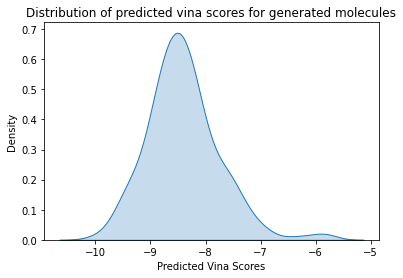

Sample trajectories:
C#CCOC(=O)CCCCCC
C=C(C)C(Cc1ccccc1)C(=O)NC(C)C(=O)NC(Cc1ccccc1)C(=O)NCCc1ccc(O)cc1
C=C(CC)C(O)CCCCCCCCCCC=CCCCCCCCCCCCCCC(=O)O
CC(=NNC(=O)c1ccccc1)c1cccs1
CC(=O)N1CCN(c2ccccc2)CC1


Policy gradient...: 100%|██████████| 15/15 [01:03<00:00,  4.25s/it]


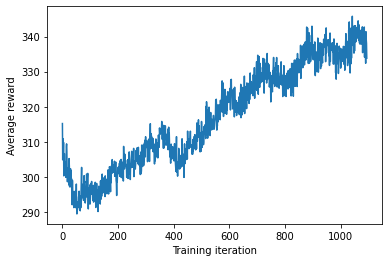

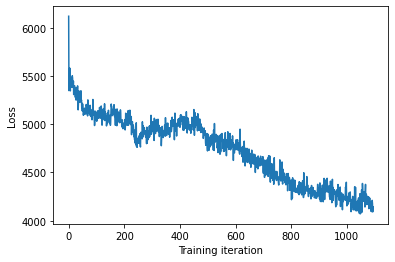

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.50it/s]


Mean value of predictions: -8.353976225218647
Proportion of valid SMILES: 0.9


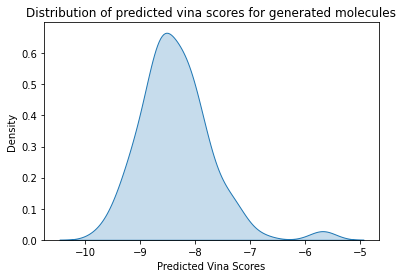

Sample trajectories:
C=C(CO)NC(=O)CCCCC
CC(=NN1CCCC1)c1ccccc1
CC(=O)N1CCC2CC(=O)N(C(=O)Oc3ccccc3)CN(CC1)C2
CC(=O)NC(Cc1ccccc1)C(=O)NC(C)Cc1ccccc1
CC(=O)NC1=C(C)CCNC1=O


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.30s/it]


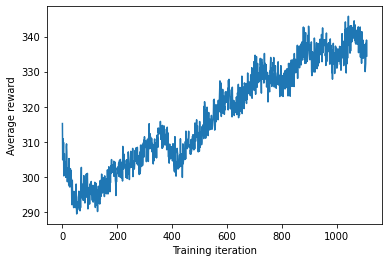

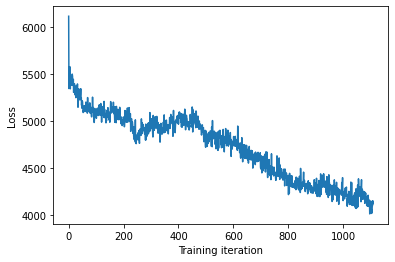

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.93it/s]


Mean value of predictions: -8.28676005589589
Proportion of valid SMILES: 0.895


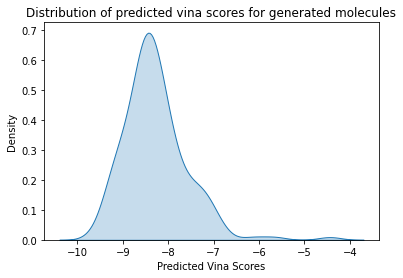

Sample trajectories:
Brc1ccccc1
C=C(C)C(N)CNCCCCCNC(=O)CCCCCC
C=CCNC(=O)c1ccccc1
CC(=CC(=O)CCCCCCCCCNC(=O)C(CC(C)C)C(=O)O)CCNCCCCCO
CC(=NNC(=O)c1ccccc1)C1CCCCC1


Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.38s/it]


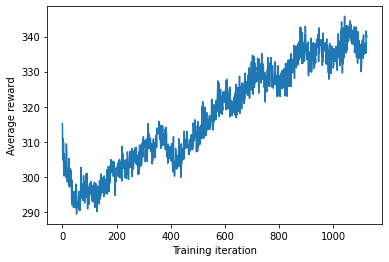

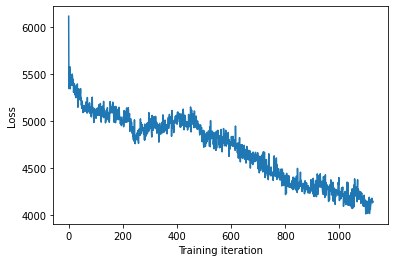

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


Mean value of predictions: -8.453648091062014
Proportion of valid SMILES: 0.915


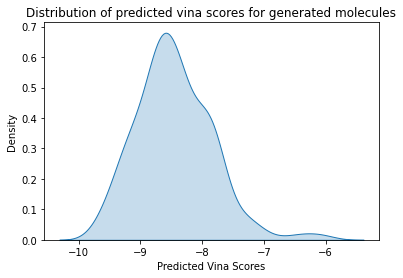

Sample trajectories:
C=C(C)Cn1cc(C2CCOCC2)nn1
C=C(c1ccccc1)c1cc(OC)ccc1OC
C=C1C(=O)N(CCc2ccccc2)C(=O)C(c2ccc(N)cc2)N1C(=N)N
C=CCC(N)=NCCCC(NC(=O)CCCCCCCCCCCCCCCCCCCCCC=CCNCC)C(=O)CS(=O)(=O)C(C)SCCCNC(=O)C(C)C
C=CCCCCC=CCCCC=C(CCCCCC)c1cnc2ccccc2c1


Policy gradient...: 100%|██████████| 15/15 [01:02<00:00,  4.16s/it]


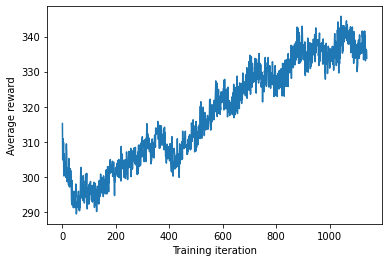

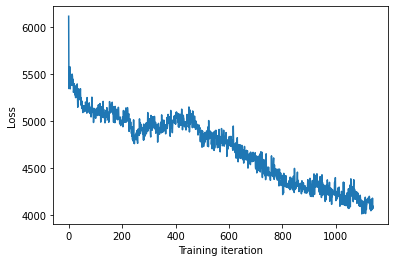

Generating molecules...: 100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


Mean value of predictions: -8.52358453034003
Proportion of valid SMILES: 0.905


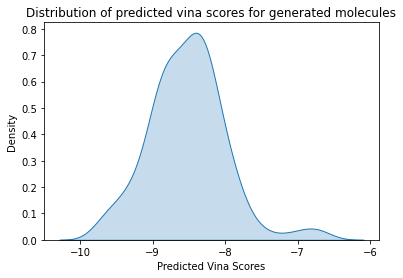

Sample trajectories:
C=C(C)C1CCC(c2ccccc2)CC1
C=CCC(C(=O)NC(CCCNCCC(C)C)C(N)=O)C(=O)NC(CCCCC)C(=O)O
C=CCCCCC(=O)NCCCCC(=O)NC(C)CCc1ccccc1
C=CCCCCCCCCCCCCCNCCCCCCCCCCCCCN
C=CCNC(=O)Cn1cc(C)cc1C


Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.27s/it]


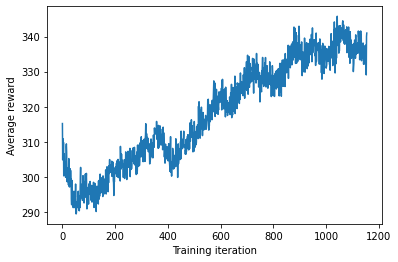

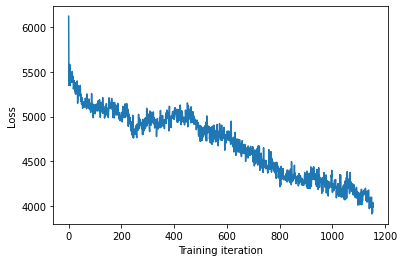

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Mean value of predictions: -8.456275609969492
Proportion of valid SMILES: 0.885


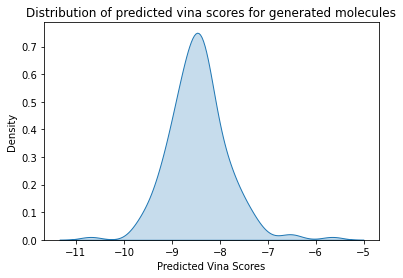

Sample trajectories:
C=C(C)C1CCC2(C)C(O)CCC3(C)C(CCC23C)C1OC(=O)c1ccccc1
C=CCCCC(=O)NCCNCC
C=CCN(C(=O)CC(=O)Nc1ccccc1)c1ccccc1OC
C=CCNC(=O)CCCCCCCCCCCCC(=O)NCCCCCCCCCC
C=CCNC(=O)COC(=O)CCCCCCCCCCCCCNCCOc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.09s/it]


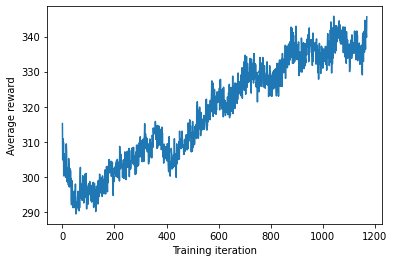

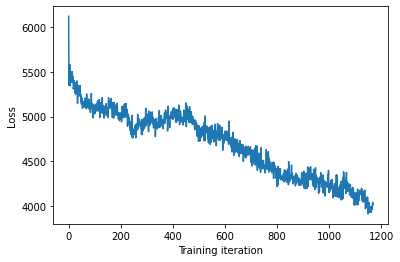

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.97it/s]


Mean value of predictions: -8.423902125853049
Proportion of valid SMILES: 0.885


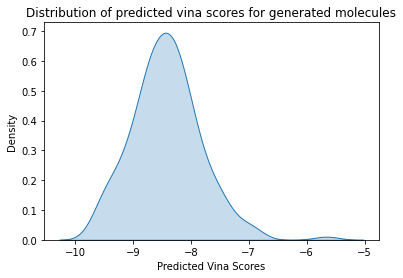

Sample trajectories:
C#CCN(CCCC(=O)O)C(=O)CCCC
C=C(C)CC(C)C(=O)NCCCc1ccccc1
C=C(CCC(C)CCCC(C)C(C)C)OC1CCCCC1
C=CCC(CC)CCC(C)C(=O)O
C=CCCCCCCCCCCCCC1(CO)Cc2ccccc2CCC1C


Policy gradient...: 100%|██████████| 15/15 [01:02<00:00,  4.15s/it]


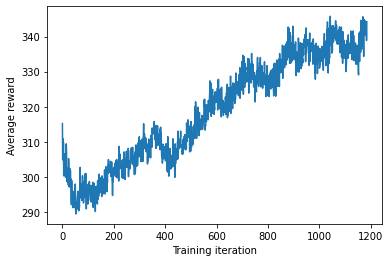

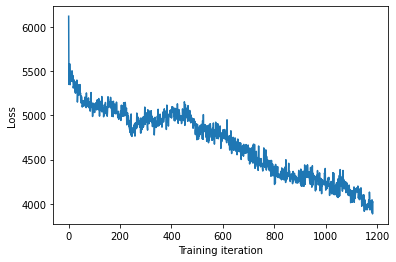

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


Mean value of predictions: -8.484746112457028
Proportion of valid SMILES: 0.905


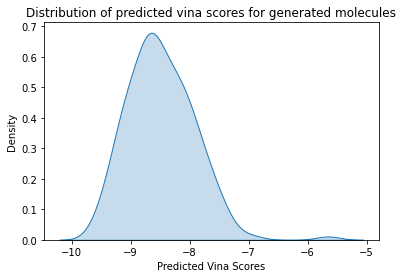

Sample trajectories:
C=CC(C)=C(C)COC(=O)CO
C=CC=CNCCC
C=CCOC(C)Cc1ccccc1
CC(=O)C(C)N1CCCCC1
CC(=O)CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCF)C(=O)O


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.04s/it]


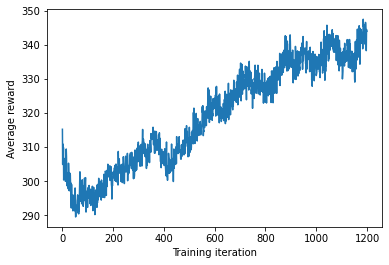

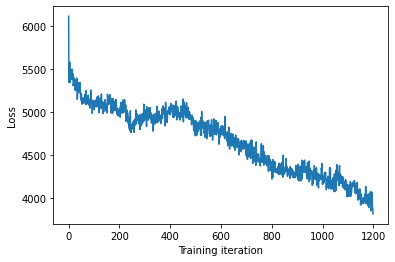

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.00it/s]


Mean value of predictions: -8.424670533673387
Proportion of valid SMILES: 0.91


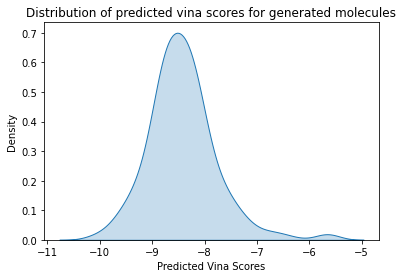

Sample trajectories:
C=C(Cc1ccccc1)C(=O)N1CCCC1C(=O)NCC
C=CCCCC(=O)NC(CCCCC)SCCc1ccccc1
C=CCNCCNCCCCCNCCCCCCCCCCCCCCCCCCCCCCCCCC=CCCCNC(C)CO
C=CCNCc1ccccc1C
CC(=O)NC(CCCCCCCCCNC(=N)N)C(=O)NCCC(C)C


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.08s/it]


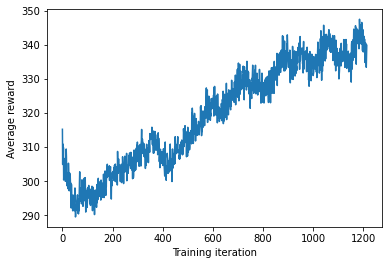

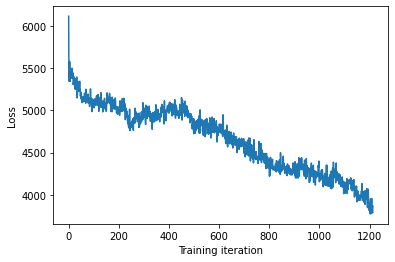

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.37it/s]


Mean value of predictions: -8.43309070740969
Proportion of valid SMILES: 0.905


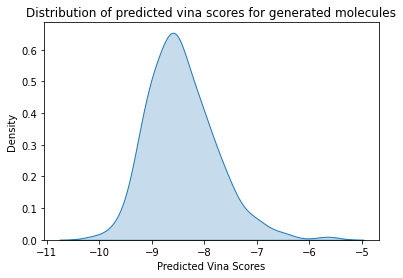

Sample trajectories:
Brc1ccccc1
C
C#CCNC(NC(=O)C(Cc1ccccc1)NC(=O)CCCCNC(=O)Nc1ccccc1)c1ccc(OC)cc1
C=CCN(CCS(C)(=N)=O)Cc1ccccc1
CC(=CCC(N)=CC(=O)NCCO)CCCCCCCCCCl


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.13s/it]


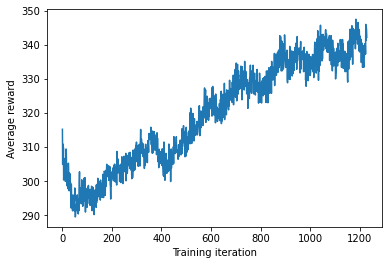

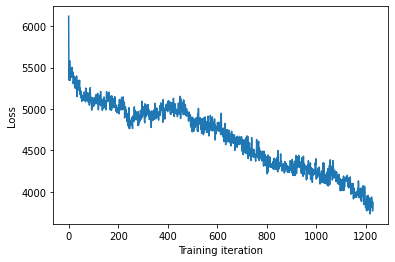

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.52it/s]


Mean value of predictions: -8.41665812305508
Proportion of valid SMILES: 0.885


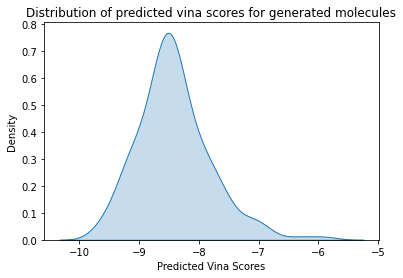

Sample trajectories:
C=C(C)Oc1ccccc1
C=C(Cl)C(=O)NCCc1ccccc1
C=CCN(CCCNC(=O)COc1ccccc1)C(=O)NC
C=CCNC(=O)c1ccccc1
C=CCNCCCCCCCCCCNCCCCNCC


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.07s/it]


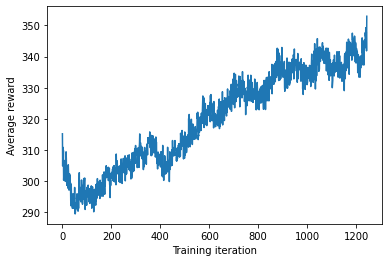

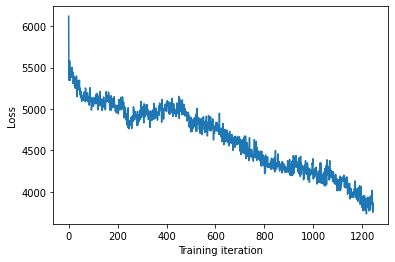

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.94it/s]


Mean value of predictions: -8.43794862862707
Proportion of valid SMILES: 0.88


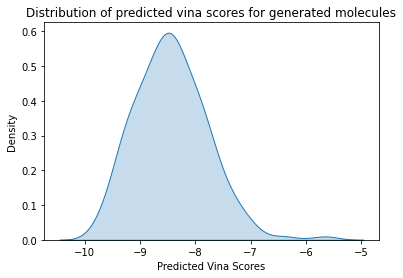

Sample trajectories:
C=C(C)C1C(=O)N(C)C1=O
CC(=NNC(=O)CCc1ccccc1)c1ccccc1
CC(=O)NCC(COc1ccccc1)NC(=O)c1ccccc1
CC(=O)NCCNC(=O)NCc1ccccc1
CC(=O)Nc1ccc(C)cc1C


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.05s/it]


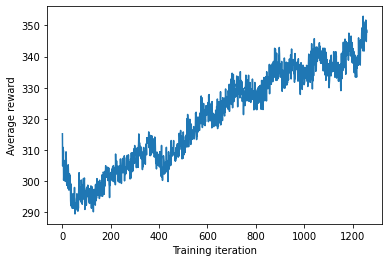

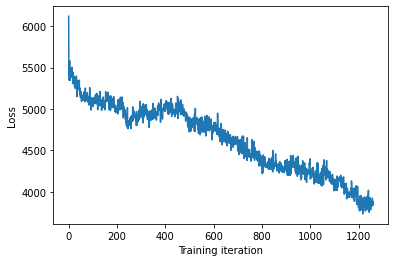

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.19it/s]


Mean value of predictions: -8.460546371949597
Proportion of valid SMILES: 0.885


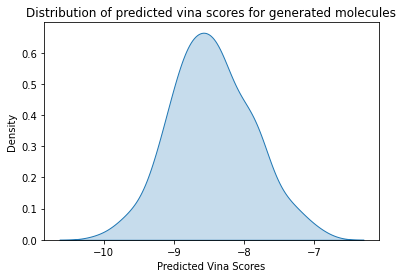

Sample trajectories:
Brc1cccc(C2CCCCO2)c1
C=C(C)C(C)CC(=O)NCc1ccccc1
C=CC1Oc2c(C)cccc2C1=O
C=CCCC(C)CCCCCCCCCCCCCCOC(C)=O
CC(=O)N1CCCCc2ccccc21


Policy gradient...: 100%|██████████| 15/15 [00:58<00:00,  3.92s/it]


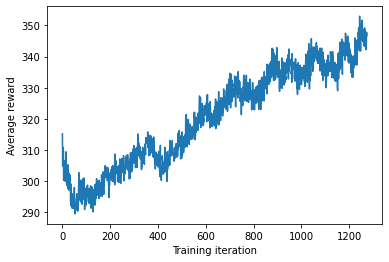

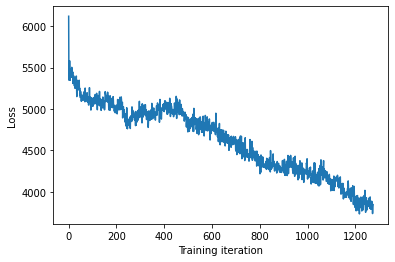

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.42it/s]


Mean value of predictions: -8.450905866918408
Proportion of valid SMILES: 0.915


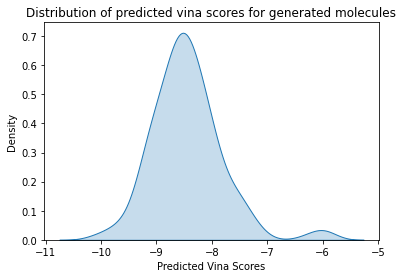

Sample trajectories:
C=C(NCCCNCCO)c1ccc(C(C)C)cc1
C=CCOC1COC(C)C1Nc1ccccc1
CC(=NNC(=O)c1ccccc1)C1CCC(C)CC1
CC(=NNC(=S)Nc1ccccn1)c1ccccc1
CC(=O)C(N)=C(C)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.10s/it]


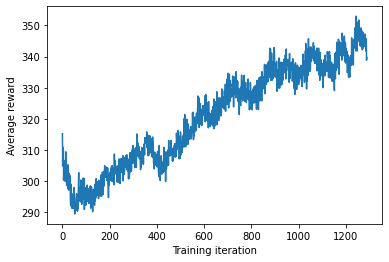

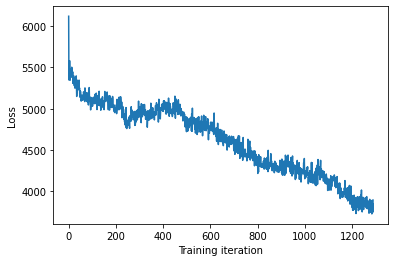

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.01it/s]


Mean value of predictions: -8.41595332267413
Proportion of valid SMILES: 0.91


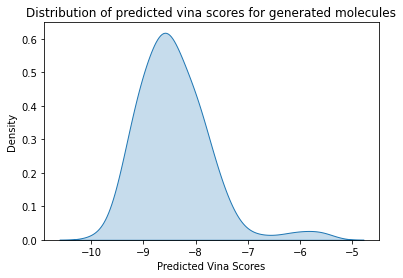

Sample trajectories:
C=C(C)C(=O)c1ccccc1
C=C1CC(C(=O)OC)c2cc(S(C)(=O)=O)ccc2N1
C=CCNC(=O)CCCNCCCCCCNCCCCCCNC(=O)NCCCCC
CC(=O)NC(CCCNC(N)=O)C(=O)NC(CCCCC(N)=O)C(=O)O
CC(=O)NCC(=O)OCCOc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.05s/it]


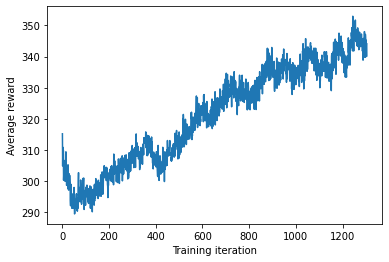

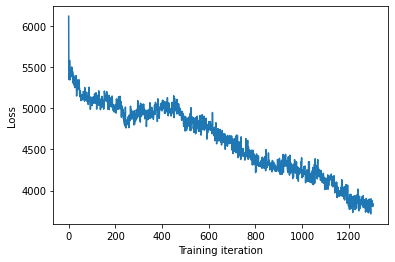

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.93it/s]


Mean value of predictions: -8.47380889218408
Proportion of valid SMILES: 0.91


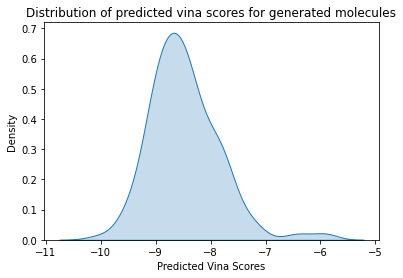

Sample trajectories:
C
C=CC=CCCC(C)CCCC(=O)NC1CCCCC1
C=CCCCNC(=O)C(CCCCCCNCCc1ccccc1)OC
CC(=NNC(=O)NCc1ccccc1)C(=O)O
CC(=NNC(=O)c1ccccc1)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.05s/it]


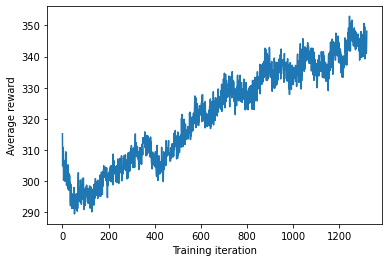

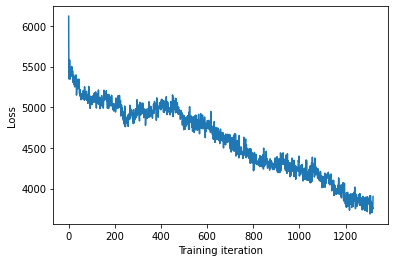

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.50it/s]


Mean value of predictions: -8.448843214407034
Proportion of valid SMILES: 0.895


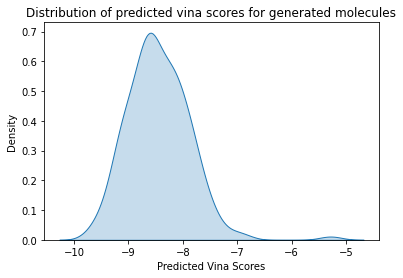

Sample trajectories:
C=NN(C(=O)CCC(=O)OCC=CCCCCCCCCCCCCCCCCCNCCCCO)C(C)(C)C
CC(=NCc1ccccc1)c1ccccc1
CC(=O)C(=O)NCC1CCCCC1
CC(=O)N1CCN(c2ccccn2)CC1
CC(=O)NNC(=O)CCNC(=O)c1ccccc1


Policy gradient...: 100%|██████████| 15/15 [00:59<00:00,  3.94s/it]


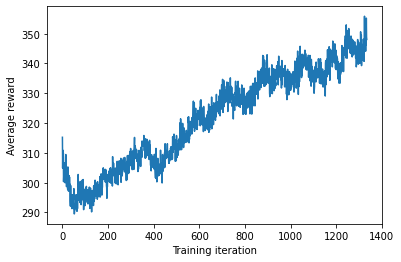

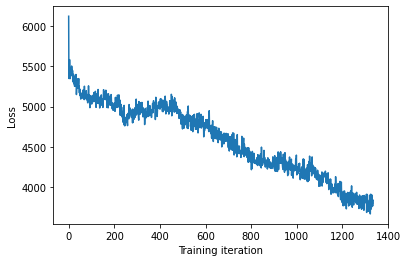

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.87it/s]


Mean value of predictions: -8.546280738635097
Proportion of valid SMILES: 0.88


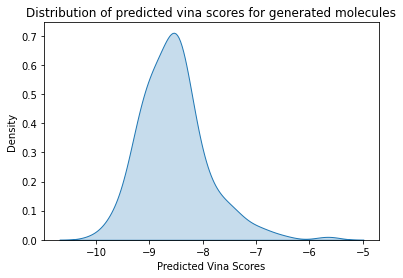

Sample trajectories:
C=C(C)CC(C)C(=O)CCCCCCCCCCCCCCCC(=O)NC(CCCc1ccccc1)C(=O)CN(C)C
C=C(C)CCC(C)C1CCC2C3CC(=O)CCCC3C1(C)C2C(=O)O
CC(=CCCC(C)=CCCC(C)C)C=C(C)CCC=CC(C)C
CC(=NNCC1C(=Cc2ccccc2O)c2ccccc21)c1ccccc1
CC(=Nc1ccccc1)C1CCNCC1


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.03s/it]


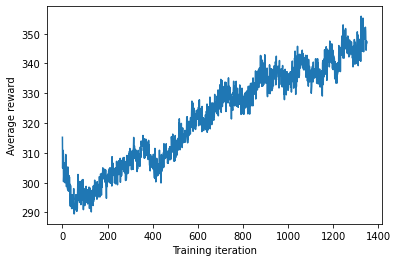

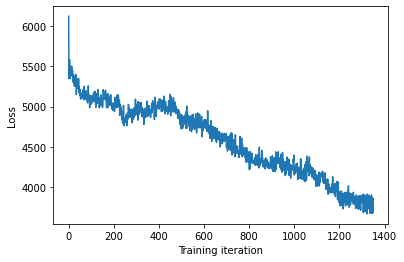

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.36it/s]


Mean value of predictions: -8.462129157190798
Proportion of valid SMILES: 0.9


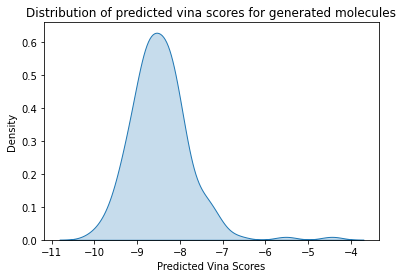

Sample trajectories:
C=C(CNCCCNc1ccc(OC)cc1)C(=O)NC(C)C
C=C(CO)CCSCC
C=CC(CC(N)=O)C(=O)NC(CC(C)C)C(O)C(Cc1ccccc1)c1ccccc1
C=CCC(C(O)c1ccccc1)N1N=C(c2ccc(Cl)cc2)SC1=O
C=CCN(CC)CC(=O)Nc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [00:59<00:00,  3.98s/it]


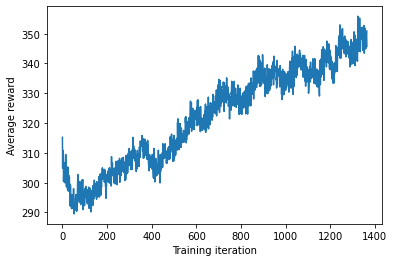

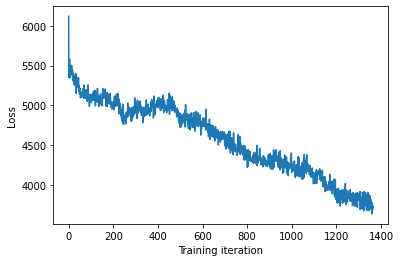

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.53it/s]


Mean value of predictions: -8.57416186601445
Proportion of valid SMILES: 0.9


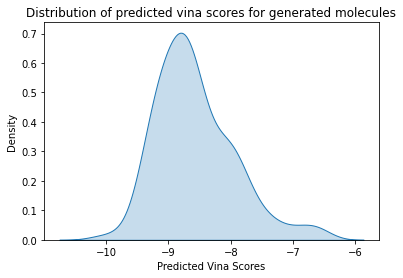

Sample trajectories:
C=C(C)NC(=O)CCCCCCCNC(=O)c1ccccc1
C=CCNC(=O)c1ccccc1
C=CCNCCCCNCCOCC(C=C)COCOCCCCCCCCCCCC(=O)CCCCC
CC(=O)NCCCCC(=O)NO
CC(=O)NCCCCCCCCCl


Policy gradient...: 100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


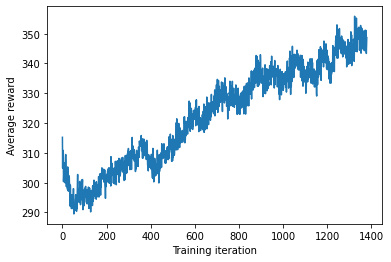

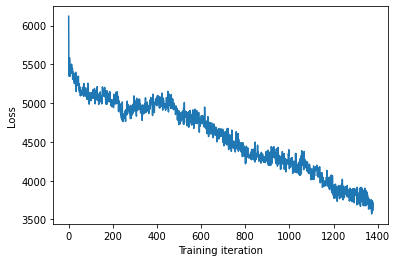

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.35it/s]


Mean value of predictions: -8.44416973402088
Proportion of valid SMILES: 0.885


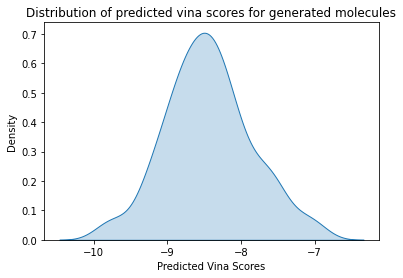

Sample trajectories:
C=C(C)CCCCCC(C)CCC(C)N
C=CCNCCCNCCCCCCCCCCCCCCCC(=O)OCC
CC(=CC(=O)c1ccccc1)CCc1ccccc1
CC(=O)NC(C)c1ccccc1
CC(=O)NC(C)n1ccnc1


Policy gradient...: 100%|██████████| 15/15 [00:59<00:00,  3.95s/it]


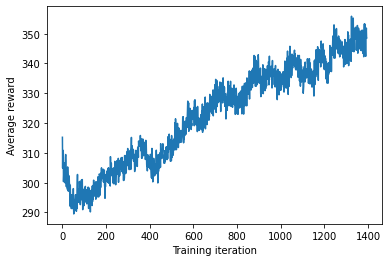

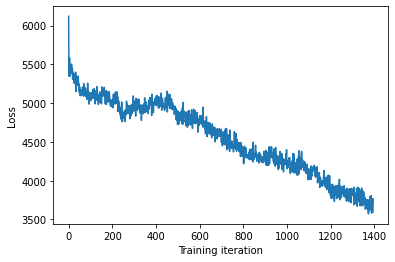

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.39it/s]


Mean value of predictions: -8.376038629193722
Proportion of valid SMILES: 0.925


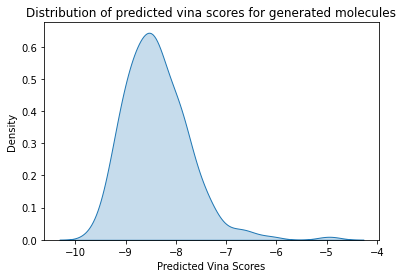

Sample trajectories:
C#CC(C)C(=O)NCCCCc1ccccc1
C=CCC(=O)Nc1ccccc1C
C=CCNCCCC(=O)O
CC(=NNC(=O)Nc1ccccc1)c1ccccc1
CC(=O)C1CC(=O)N=C1N


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.06s/it]


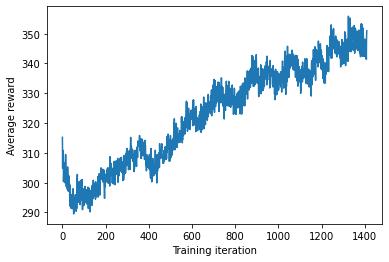

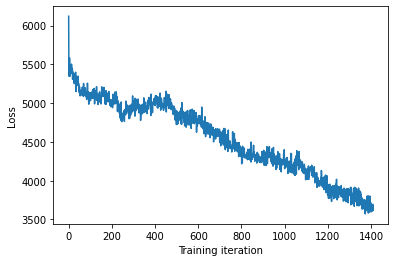

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.29it/s]


Mean value of predictions: -8.446274246235284
Proportion of valid SMILES: 0.9


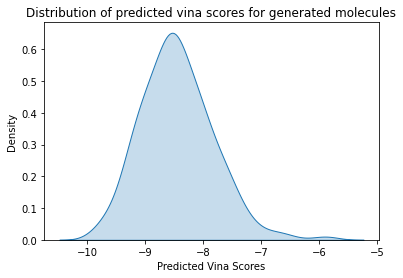

Sample trajectories:
C=CCN1C(=O)N(CC(C)O)CC1C
C=CCNC1CCCC2CCC1(C)CCCC1C(C)(C)CCCC21C
C=CNC(=O)COC(=O)NC(C)CCC(=O)OC1CCCCC1
CC(=O)NC(CC(=O)O)c1ccccc1
CC(=O)Nc1ccc(S(N)(=O)=O)cc1


Policy gradient...: 100%|██████████| 15/15 [00:59<00:00,  3.98s/it]


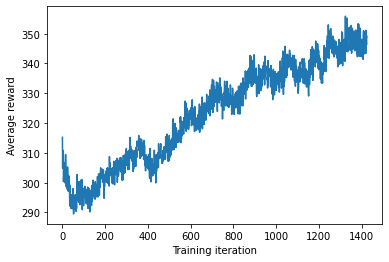

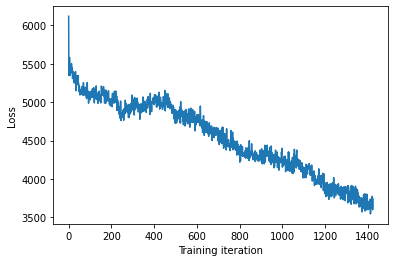

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.52it/s]


Mean value of predictions: -8.57414957543947
Proportion of valid SMILES: 0.875


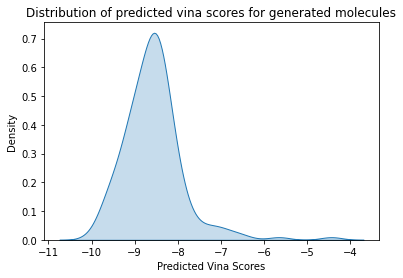

Sample trajectories:
C=C(CC(O)C1OC1OC)OC
C=CC(=O)Nc1ccccc1
C=CCCCCCCCCCNCCCC
C=CCN1C(=O)C(COc2ccccc2)C(C)=C1C
CC(=O)CCCCCNC(=O)Cc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.09s/it]


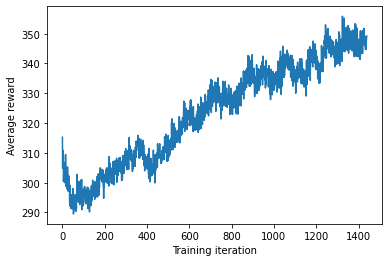

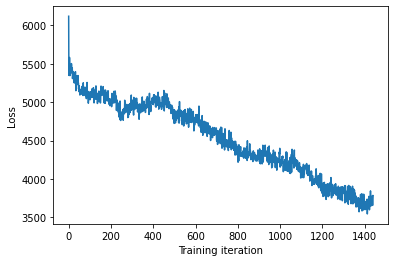

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.30it/s]


Mean value of predictions: -8.41852678124458
Proportion of valid SMILES: 0.905


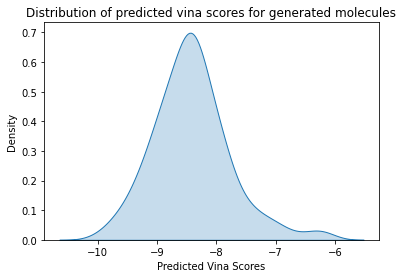

Sample trajectories:
C=CCOc1cccc(OC)c1
CC(=NNC(=O)c1ccccc1)c1ccccc1
CC(=O)N1CCN(Cc2ccccc2)CC1
CC(=O)NC(=NNC(=N)N)C(=O)O
CC(=O)NCCF


Policy gradient...: 100%|██████████| 15/15 [00:59<00:00,  4.00s/it]


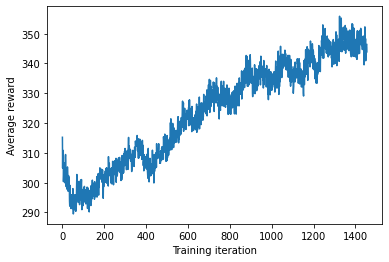

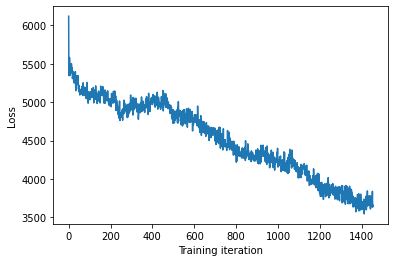

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 14.83it/s]


Mean value of predictions: -8.44358501096462
Proportion of valid SMILES: 0.86


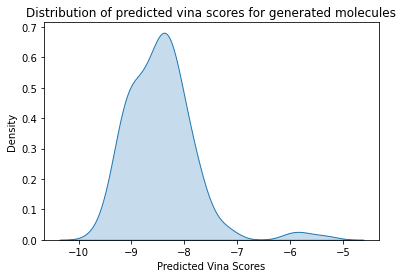

Sample trajectories:
C=C(C)OC(=O)c1ccccc1
C=CCN(CC)CC
CC(=NNC(=O)CC(C)C)C(c1ccccc1)c1ccccc1
CC(=O)NCC(C)C
CC(=O)NCCc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.05s/it]


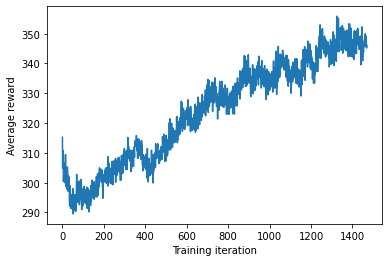

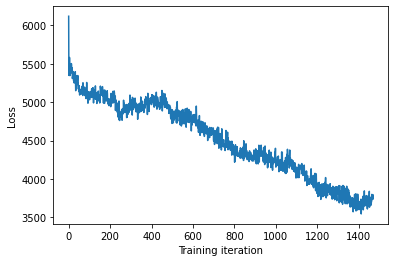

Generating molecules...: 100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


Mean value of predictions: -8.451797196466911
Proportion of valid SMILES: 0.885


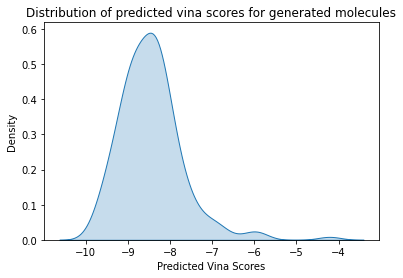

Sample trajectories:
C=CCCCCCCCNCCCCCCCCCNC(=O)CCCCCCCCCCCCCCC
C=Cc1cccc(C(=O)NC(CC(=O)O)C(C)CC)c1
C=NNC(C)C
CC(=NNC(=O)c1ccccc1)c1ccccc1
CC(=O)C(N)CNCC(C)C


Policy gradient...: 100%|██████████| 15/15 [01:00<00:00,  4.04s/it]


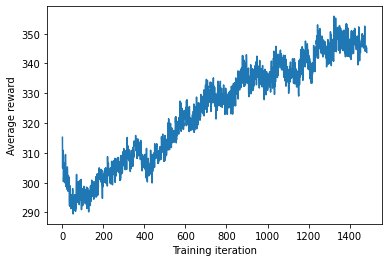

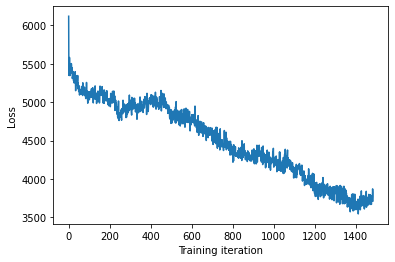

Generating molecules...: 100%|██████████| 200/200 [00:12<00:00, 15.93it/s]


Mean value of predictions: -8.47524701442556
Proportion of valid SMILES: 0.93


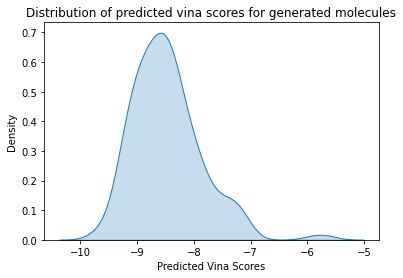

Sample trajectories:
C=C(C)CCCCC(C)=CC=CCC=CCCCCCCCCCCCC(=O)O
C=CCC(C)CCC(=O)O
C=CCCC(CCCC(=O)O)C(=O)OCCC
C=CCCCNC(=O)NCC
C=CCCNC(=S)NCc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [01:01<00:00,  4.12s/it]


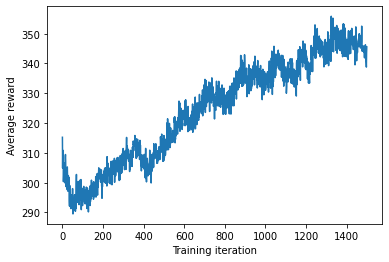

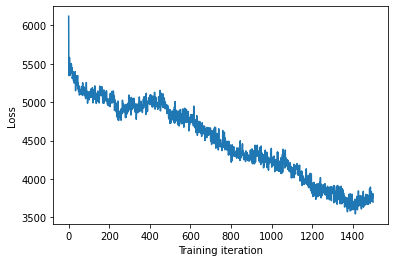

Generating molecules...: 100%|██████████| 200/200 [00:13<00:00, 15.31it/s]


Mean value of predictions: -8.468461083394137
Proportion of valid SMILES: 0.895


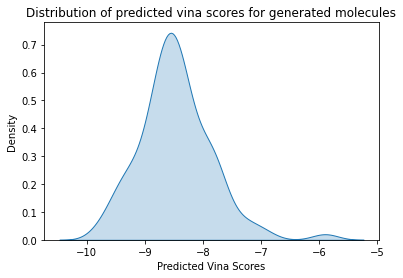

Sample trajectories:
C=C(C)N1CCN(CCNC2CCCCC2)CC1
C=CC(NC(=O)C(CC(C)C)NC(=O)NCC(C)C)C(=O)C(C)(C)C
C=CCCCCC(C)N(C)CCCCC
C=CCNC(=O)CN(C(=O)CC)C(C)C(=O)O
CC(=CCCCC(=O)NCC(O)CNCCCCCC(=O)O)COC(=O)C(C)(C)C


In [ ]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_min.policy_gradient(gen_data, n_batch=5, get_features=get_fp)
        rewards_min.append(simple_moving_average(rewards_min, cur_reward)) 
        rl_losses_min.append(simple_moving_average(rl_losses_min, cur_loss))
    
    plt.plot(rewards_min)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_min)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_min.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Generating molecules...: 100%|██████████| 6000/6000 [05:56<00:00, 16.81it/s]


Mean value of predictions: -8.463029364847435
Proportion of valid SMILES: 0.7838333333333334


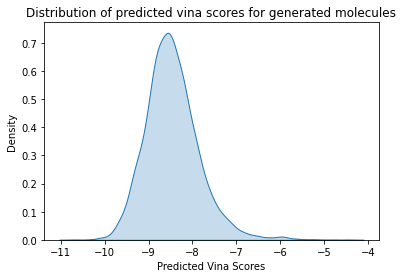

In [ ]:
smiles_biased_min, prediction_biased_min = estimate_and_update(RL_min.generator, 
                                                           my_predictor,
                                                           n_to_generate=6000)

**after 750 itr**

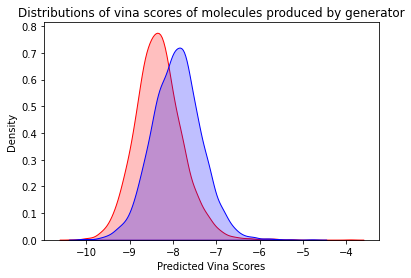

In [ ]:
sns.kdeplot(prediction_biased_min, label='Minimized', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='blue')
plt.xlabel('Predicted Vina Scores')
plt.title('Distributions of vina scores of molecules produced by generator')
plt.show()

**after 1500 iter**

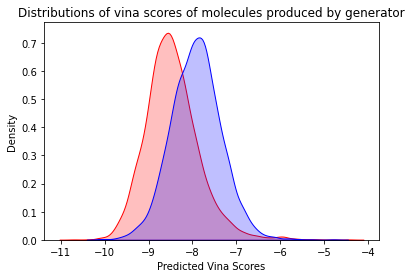

In [ ]:
sns.kdeplot(prediction_biased_min, label='Minimized', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='blue')
plt.xlabel('Predicted Vina Scores')
plt.title('Distributions of vina scores of molecules produced by generator')
plt.show()

## Drawing random molecules

Now we will draw some random compounds from the biased library:

In [ ]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

### Molecules with minimized vina score

In [ ]:
generated_mols_min = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased_min]
sanitized_gen_mols_min = [generated_mols_min[i] 
                          for i in np.where(np.array(generated_mols_min) != None)[0]]

In [ ]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols_min), n_to_draw)
mols_to_draw_min = [sanitized_gen_mols_min[i] for i in ind]
legends = ['vina score = ' + str(prediction_biased_min[i]) for i in ind]

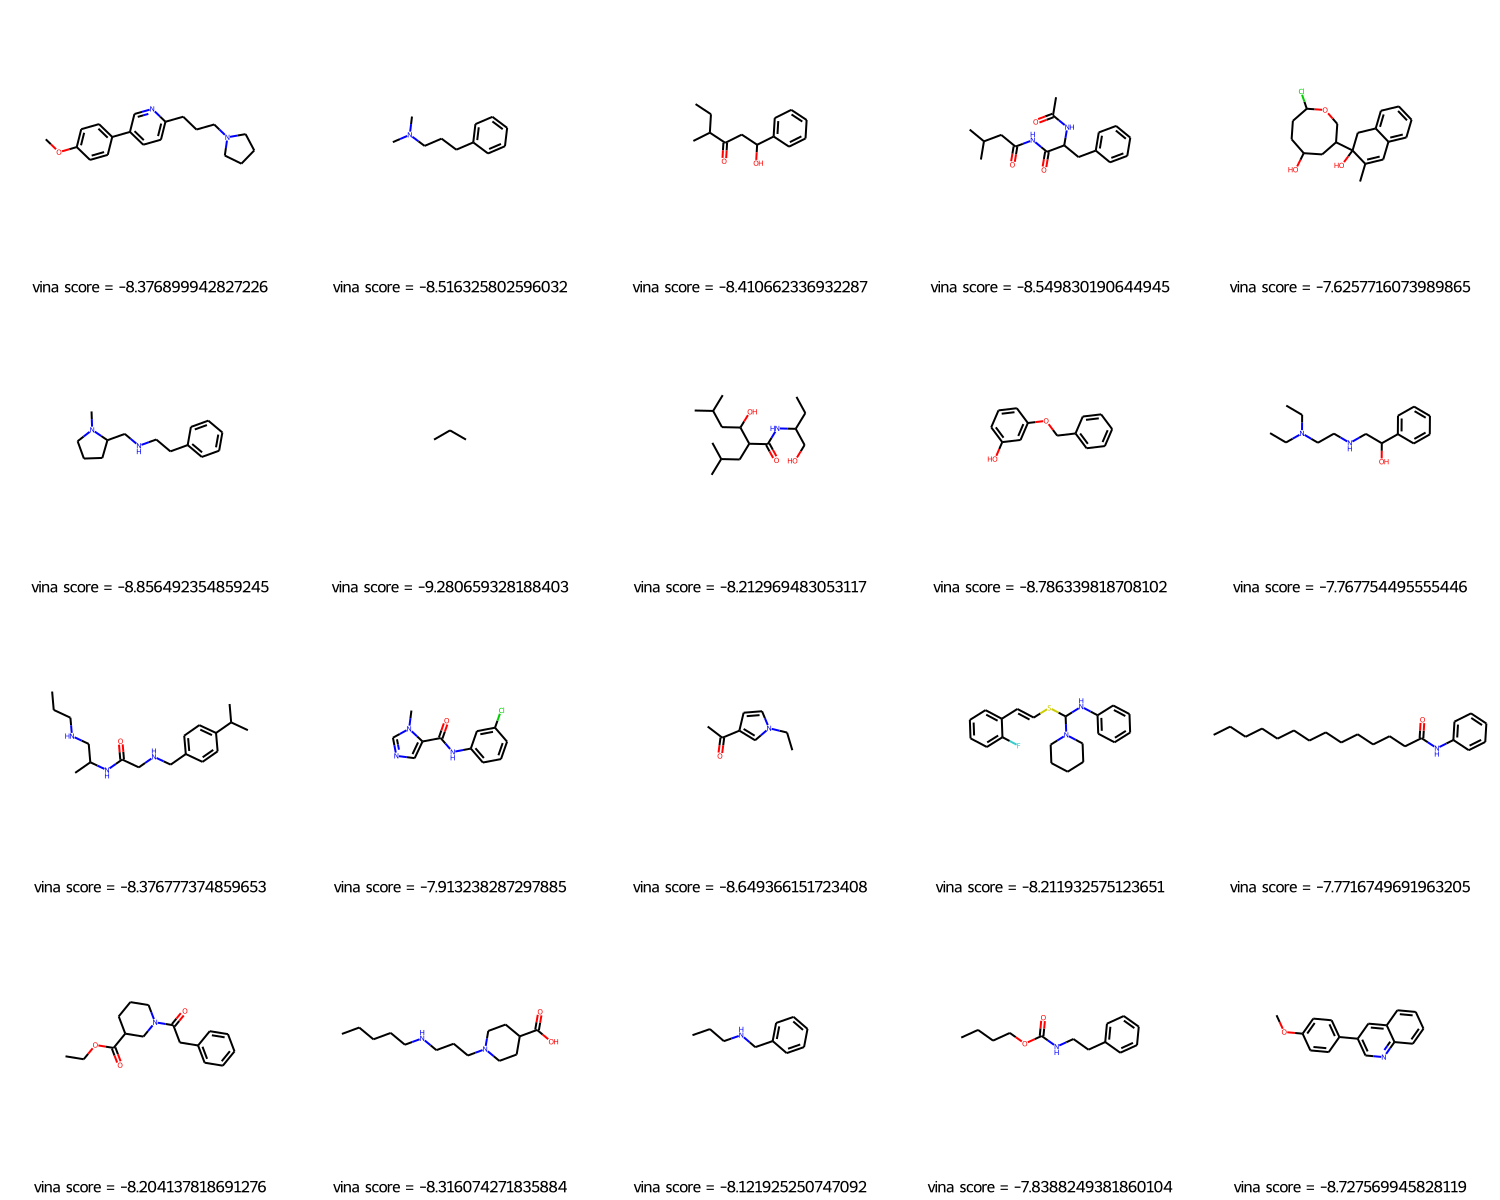

In [ ]:
Draw.MolsToGridImage(mols_to_draw_min, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)

In [ ]:
smiles_df = pd.DataFrame(smiles_biased_min, columns=['smiles'])

vina_df = pd.DataFrame(prediction_biased_min, columns=['vina_score'])

In [ ]:
final_df = pd.concat([smiles_df,vina_df],axis=1)
final_df

,smiles,vina_score
0,Brc1ccccc1,-8.392218
1,C,-10.076636
2,C#CCOCCCCCCCCCCCCCCCCCCC,-8.153758
3,C(=CC1CCCC1)c1ccccc1,-8.534201
4,C(=NC1CCNC1)c1ccccc1,-8.826529
...,...,...
4698,c1ccc(NCCCNCCCCCCCCCNCC2CCC2)cc1,-8.969861
4699,c1ccc(NCCCc2c3c(nc4ccccc24)CCCC3)nc1,-8.163520
4700,c1ccc(OCCNCC2CCCCC2)cc1,-8.810580
4701,c1ccccc1,-8.846458


Store the generated molecules and vina scores as a dataframe

In [ ]:
final_df.to_csv('/content/gdrive/MyDrive/Datasets/Drug Repurposing/gan_df_1500.csv')